# ***TOPIC: DỰ ĐOÁN ĐIỂM ĐÁNH GIÁ, THÀNH CÔNG CỦA BỘ PHIM ÁP DỤNG THUẬT TOÁN K-NEAREST NEIGHBORS***

### Giới thiệu về tập dữ liệu: Bộ dữ liệu The Movie Database (TMDb) cung cấp thông tin về ngành công nghiệp điện ảnh và khả năng dự đoán thành công của bộ phim trước khi ra mắt. Với thông tin chi tiết về cốt truyện, diễn viên, đoàn làm phim, ngân sách và doanh thu cho hàng nghìn bộ phim, bộ dữ liệu này là nguồn tài nguyên quan trọng. Sự cập nhật về diễn viên và đội ngũ sản xuất, cùng với các trường dữ liệu mới như homepage, id, original_title, và tagline, tạo điều kiện cho việc khám phá đa dạng và tiềm năng của nó. Phân loại phim, nghiên cứu sự phân định giữa hãng phim lớn và độc lập, hay đánh giá độ ảnh hưởng của các yếu tố khác nhau là những hướng đi có thể đạt được từ bộ dữ liệu này.
### Data Source: https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata

In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession \
    .builder \
    .appName("PROJECT") \
    .master("spark://172.17.23.93:7077") \
    .getOrCreate()

In [4]:
spark

In [5]:
# Khởi tạo SparkContext
sc = spark.sparkContext

# Import các thư viện cần thiết

In [6]:
# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from plotnine import *


# Pyspark
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as f
from pyspark.sql.window import Window

from operator import add, getitem
from collections import Counter

from numpy.linalg import norm
from math import sqrt

import json
from wordcloud import WordCloud

# Đọc dữ liệu

In [7]:
df_credits = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .option("escape", '"')\
    .option("na_values", ["", " ", "N/A", "NA"])\
    .load("tmdb_5000_credits.csv")

df_credits.cache()
df_credits.count()

4803

In [8]:
df_movies = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .option("escape", '"')\
    .option("na_values", ["", " ", "N/A", "NA"])\
    .load("tmdb_5000_movies.csv")

df_movies.cache()
df_movies.count()

4806

# EDA

In [9]:
# Hiển thị thông tin dữ liệu
num_rows = df_credits.count()
print(f"Số dòng: {num_rows}")
num_columns = len(df_credits.columns)
print(f"Số cột: {num_columns}")

display(df_credits)
df_credits.printSchema()

Số dòng: 4803
Số cột: 4


DataFrame[movie_id: int, title: string, cast: string, crew: string]

root
 |-- movie_id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- crew: string (nullable = true)



In [10]:
# Hiển thị thông tin dữ liệu
num_rows = df_movies.count()
print(f"Số dòng: {num_rows}")
num_columns = len(df_movies.columns)
print(f"Số cột: {num_columns}")

display(df_movies)
df_movies.printSchema()

Số dòng: 4806


Số cột: 20


DataFrame[budget: string, genres: string, homepage: string, id: string, keywords: string, original_language: string, original_title: string, overview: string, popularity: string, production_companies: string, production_countries: string, release_date: string, revenue: string, runtime: string, spoken_languages: string, status: string, tagline: string, title: string, vote_average: double, vote_count: string]

root
 |-- budget: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: string (nullable = true)



## Merging the two csv files

In [11]:
df = df_movies.join(df_credits, df_movies["id"] == df_credits["movie_id"], "inner")

Xóa các cột trùng tên hay trùng ý nghĩa như id của phim, title của phim

In [12]:
df = df.drop("title","movie_id")

In [13]:
# Hiển thị thông tin dữ liệu
num_rows = df.count()
print(f"Số dòng: {num_rows}")
num_columns = len(df.columns)
print(f"Số cột: {num_columns}")

display(df)
df.printSchema()

Số dòng: 4803
Số cột: 21


DataFrame[budget: string, genres: string, homepage: string, id: string, keywords: string, original_language: string, original_title: string, overview: string, popularity: string, production_companies: string, production_countries: string, release_date: string, revenue: string, runtime: string, spoken_languages: string, status: string, tagline: string, vote_average: double, vote_count: string, cast: string, crew: string]

root
 |-- budget: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- crew: string (nullable = true)



In [14]:
# Chuyển các thuộc tính về kiểu dữ liệu thích hợp
df = df.withColumn("budget", col("budget").cast("integer"))
df = df.withColumn("id", col("id").cast("integer"))
df = df.withColumn("popularity", col("popularity").cast("double"))
df = df.withColumn("revenue", col("revenue").cast("integer"))
df = df.withColumn("runtime", col("runtime").cast("integer"))
df = df.withColumn("vote_count", col("vote_count").cast("integer"))

In [15]:
# Xem 10 dòng đầu tiên
df.show(10)

+---------+--------------------+--------------------+------+--------------------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+------------+----------+-------+--------------------+--------+--------------------+------------+----------+--------------------+--------------------+
|   budget|              genres|            homepage|    id|            keywords|original_language|      original_title|            overview|popularity|production_companies|production_countries|release_date|   revenue|runtime|    spoken_languages|  status|             tagline|vote_average|vote_count|                cast|                crew|
+---------+--------------------+--------------------+------+--------------------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+------------+----------+-------+--------------------+--------+--------------------+------------+----------+-----------

In [16]:
# Thống kê thống kê các thuộc tính định lượng như: count, max, min, mean, stddev, tứ phân vị...
df.summary().show()

+-------+--------------------+--------------------+--------------------+------------------+--------------------+-----------------+------------------+--------------------+------------------+--------------------+--------------------+------------+--------------------+------------------+--------------------+---------------+--------------------+------------------+-----------------+--------------------+--------------------+
|summary|              budget|              genres|            homepage|                id|            keywords|original_language|    original_title|            overview|        popularity|production_companies|production_countries|release_date|             revenue|           runtime|    spoken_languages|         status|             tagline|      vote_average|       vote_count|                cast|                crew|
+-------+--------------------+--------------------+--------------------+------------------+--------------------+-----------------+------------------+-------

Thống kê số dòng null trong tập dữ liệu

In [17]:
# Check if dataset have missing values
null_counts = df.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts_pandas = null_counts.toPandas().transpose()
null_counts_pandas.columns = ["Null Counts"]
display(null_counts_pandas)

,Null Counts
budget,0
genres,0
homepage,3091
id,0
keywords,0
original_language,0
original_title,0
overview,3
popularity,3
production_companies,3


In [18]:
missing_samples_row = df.agg(count(when(
    col("budget").isNull() | col("genres").isNull() | col("homepage").isNull() | col("id").isNull() | 
    col("keywords").isNull() | col("original_language").isNull() | col("original_title").isNull() | 
    col("overview").isNull() | col("popularity").isNull() | col("production_companies").isNull() | 
    col("production_countries").isNull() | col("release_date").isNull() | col("revenue").isNull() | 
    col("runtime").isNull() | col("spoken_languages").isNull() | col("status").isNull() | 
    col("tagline").isNull() | col("vote_average").isNull() | col("vote_count").isNull() | 
    col("cast").isNull() | col("crew").isNull(), 1)
).alias("missing_samples")).first()

missing_samples = missing_samples_row["missing_samples"]
percent_missing_samples = (missing_samples / df.count()) * 100

print('Number missing samples:', missing_samples)
print('Percent missing samples:', percent_missing_samples)


Number missing samples: 3311
Percent missing samples: 68.93608161565689


Có thể thấy có 3311/4803 dòng dữ liệu bị mất dữ liệu và chiếm khoảng 68,9 % => Mất mát dữ liệu khá lớn

In [19]:
# Thống kê số lượng giá trị null cho từng cột
null_counts = df.agg(*[count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
total_null_counts_percent = null_counts.agg(*[sum(col(c)).alias(c) for c in df.columns])
# Percent missing data
total_rows = df.count()
null_percentages = null_counts.select(*[(col(c) / total_rows).alias(c + '_percent') for c in null_counts.columns])
# Hiển thị
missing_data = null_counts.union(null_percentages).toPandas().transpose()
missing_data.columns = ["Number missing","Percent %"]
missing_data = missing_data.sort_values(by="Percent %", ascending=False)
display(missing_data)

,Number missing,Percent %
homepage,3091.0,0.643556
tagline,846.0,0.176140
runtime,5.0,0.001041
release_date,4.0,0.000833
revenue,4.0,0.000833
production_countries,3.0,0.000625
spoken_languages,3.0,0.000625
vote_count,3.0,0.000625
vote_average,3.0,0.000625
overview,3.0,0.000625


Ta thấy các 13 thuộc tính có giá trị null là : homepage,overview, popularity, production_companies, production_countries, release_date, revenue, runtime, spoken_languages, status,tagline,vote_average, vote_count. Trong đó cột homepage có độ mất mát dữ lớn (64%) tiếp đến là tagline (17%) và các thuộc tính khác nhưng không đáng kẻ (<1%) 						

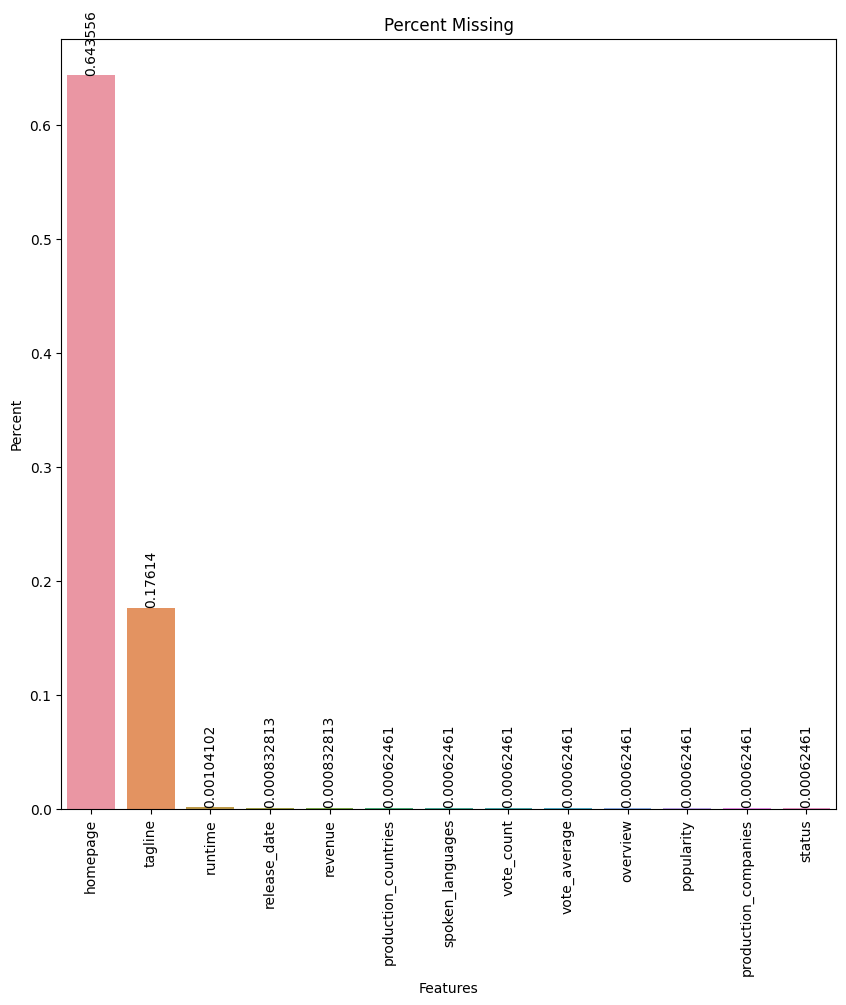

In [20]:
plt.figure(figsize=(10, 10))
ax = sns.barplot(x=missing_data.head(13).index, y=missing_data.head(13)['Percent %'])
ax.bar_label(ax.containers[0],rotation=90)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Percent')
plt.title('Percent Missing')

plt.show()

# Data preprocessing

## Handling missing data

In [21]:
# Xóa tất cả các dòng đều null ở tất cả các thuộc tính
df = df.dropna(how='all')

In [22]:
# Loại bỏ cột 'homepage'
df = df.drop("homepage")

In [23]:
# Thay thế giá trị null trong cột "tagline" bằng giá trị "No tag line available"
df = df.na.fill("No tag line available", subset=["tagline"])

In [24]:
# Với các cột có số lượng giá trị null không đáng kể (<1%) ta sẽ tiến hành xóa các dòng có giá trị null
df = df.dropna()

In [25]:
# Check null againt
null_counts = df.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts_pandas = null_counts.toPandas().transpose()
null_counts_pandas.columns = ["Null Counts"]
display(null_counts_pandas)

,Null Counts
budget,0
genres,0
id,0
keywords,0
original_language,0
original_title,0
overview,0
popularity,0
production_companies,0
production_countries,0


## Xử lý các cột ở định dạng json: genres, keywords, production_companies, production_countries,spoken_languages, cast, crew

### genres, keywords, production_companies, production_countries,spoken_languages

Đối với các thuộc tính ở định dạng json như:
+ genres: Thể loại mà bộ phim thuộc về. Bao gồm thông tin về thể loại của bộ phim (ví dụ: Hành động, Drama, Hài, Chính kịch).
+ keywords: Các từ khóa liên quan đến bộ phim. Bao gồm các từ hoặc cụm từ quan trọng liên quan đến bộ phim.
+ production_companies: Thông tin về các công ty sản xuất tham gia vào việc sản xuất bộ phim
+ production_countries: Thông tin về các quốc gia mà bộ phim được sản xuất
+ spoken_languages: Thông tin về các ngôn ngữ được sử dụng trong bộ phim

Đối với 5 thuộc tính trên ta sẽ trích xuất trường name trong mỗi đối tượng JSON để phân tích

In [26]:
json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']

# Hàm UDF để chuyển đổi JSON thành chuỗi tên phân cách bằng dấu ","
@udf(StringType())
def json_to_names(json_data):
    data = json.loads(json_data)
    return ','.join([x['name'] for x in data])

for column in json_columns:
    df = df.withColumn(column, json_to_names(col(column)))

Kiểm tra 1 thuộc tính "genres" sau khi đã trích xuất và chuyển đổi

In [27]:
df.select("genres").show(truncate=False)

+----------------------------------------+
|genres                                  |
+----------------------------------------+
|Adventure,Fantasy,Action                |
|Action,Adventure,Crime                  |
|Action,Crime,Drama,Thriller             |
|Action,Adventure,Science Fiction        |
|Fantasy,Action,Adventure                |
|Animation,Family                        |
|Action,Adventure,Science Fiction        |
|Adventure,Fantasy,Family                |
|Action,Adventure,Fantasy                |
|Adventure,Fantasy,Action,Science Fiction|
|Adventure,Action,Thriller,Crime         |
|Adventure,Fantasy,Action                |
|Action,Adventure,Western                |
|Action,Adventure,Fantasy,Science Fiction|
|Adventure,Family,Fantasy                |
|Science Fiction,Action,Adventure        |
|Adventure,Action,Fantasy                |
|Action,Comedy,Science Fiction           |
|Action,Adventure,Fantasy                |
|Action,Adventure,Fantasy                |
+----------

### cast

Thuộc tính cast: Thông tin về dàn diễn viên của bộ phim. Bao gồm chi tiết về các diễn viên như
+ cast_id: Mã id của diễn viên trong danh sách diễn viên của bộ phim.
+ character: Tên nhân vật mà diễn viên đó đảm nhận trong bộ phim.
+ credit_id: Mã id đội ngũ sản xuất có liên quan đến việc đóng góp của diễn viên trong bộ phim
+ gender: Giới tính của diễn viên (0 là không xác định, 1 là nữ, 2 là nam).
+ id: Mã id của diễn viên trong hệ thống.
+ name: Tên của diễn viên.
+ order: Một số nguyên đại diện cho thứ tự xuất hiện của diễn viên trong danh sách diễn viên của bộ phim.

Tuy nhiên số lượng diễn viên quá nhiều (chính, phụ, quần chúng) nên tiện cho việc xử lý và phân tích ta chỉ tiến hành lấy thông tin tên của 3 diễn viên chính (ảnh hưởng) của bộ phim dựa theo order là 3 đối tượng JSON đầu tiên 

In [28]:
json_columns = ['cast']

# Hàm UDF để chuyển đổi JSON thành chuỗi tên phân cách bằng dấu ","
@udf(StringType())
def json_to_names(json_data):
    data = json.loads(json_data)
    # Lấy trường name của 3 đối tượng object đầu tiên
    return ','.join([x['name'] for x in data[:3]])

for column in json_columns:
    df = df.withColumn('actor', json_to_names(df[column]))

Kiểm tra thuộc tính "actor" sau khi đã trích xuất và chuyển đổi từ thuộc tính "cast"

In [29]:
# Hiển thị kết quả
df.select("actor").show(truncate=False)

+----------------------------------------------+
|actor                                         |
+----------------------------------------------+
|Johnny Depp,Orlando Bloom,Keira Knightley     |
|Daniel Craig,Christoph Waltz,Léa Seydoux      |
|Christian Bale,Michael Caine,Gary Oldman      |
|Taylor Kitsch,Lynn Collins,Samantha Morton    |
|Tobey Maguire,Kirsten Dunst,James Franco      |
|Zachary Levi,Mandy Moore,Donna Murphy         |
|Robert Downey Jr.,Chris Hemsworth,Mark Ruffalo|
|Daniel Radcliffe,Rupert Grint,Emma Watson     |
|Ben Affleck,Henry Cavill,Gal Gadot            |
|Brandon Routh,Kevin Spacey,Kate Bosworth      |
|Daniel Craig,Olga Kurylenko,Mathieu Amalric   |
|Johnny Depp,Orlando Bloom,Keira Knightley     |
|Johnny Depp,Armie Hammer,William Fichtner     |
|Henry Cavill,Amy Adams,Michael Shannon        |
|Ben Barnes,William Moseley,Anna Popplewell    |
|Robert Downey Jr.,Chris Evans,Mark Ruffalo    |
|Johnny Depp,Penélope Cruz,Ian McShane         |
|Will Smith,Tommy Le

### crew

Thuộc tính crew: Thông tin về đoàn làm phim của bộ phim. Bao gồm chi tiết về đội ngũ sản xuất, như đạo diễn, nhà sản xuất, v.v.
+ credit_id: Mã id đội ngũ sản xuất có liên quan đến việc đóng góp của thành viên trong đội ngũ sản xuất của bộ phim
+ department: Bộ phận hoặc bộ môn trong đội ngũ sản xuất mà thành viên đó đảm nhận. Ví dụ, "Editing" cho biết thành viên này thuộc bộ phận chỉnh sửa.
+ gender: Giới tính của thành viên (0 là không xác định, 1 là nữ, 2 là nam).
+ id: Mã id của thành viên trong hệ thống.
+ job: Nghề nghiệp hoặc công việc cụ thể mà thành viên đó đảm nhận trong đội ngũ sản xuất. Ví dụ, "Editor" cho biết thành viên này là người chỉnh sửa.
+ name: Tên của thành viên trong đội ngũ sản xuất.

Tuy nhiên hầu hết yếu tố góp phần vào sự thành công của bộ phim đều dưa trên đạo diễn - job: "Director", Vì vậy đối với thuộc tính trên ta chỉ trích xuất tên của đạo diễn của bộ phim

In [30]:
json_columns = ['crew']

# Hàm UDF để chuyển đổi JSON thành chuỗi tên phân cách bằng dấu ","
@udf(StringType())
def json_to_names(json_data):
    data = json.loads(json_data)
    # Chi lay name của job là "Director" 
    return ','.join([x['name'] for x in data if x['job'] == 'Director'][:3])

# Áp dụng UDF cho mỗi cột JSON
for column in json_columns:
    df = df.withColumn('director', json_to_names(df[column]))

Kiểm tra thuộc tính "director" sau khi đã trích xuất và chuyển đổi từ thuộc tính "crew"

In [31]:
# Hiển thị kết quả
df.select("director").show(truncate=False)

+-------------------------+
|director                 |
+-------------------------+
|Gore Verbinski           |
|Sam Mendes               |
|Christopher Nolan        |
|Andrew Stanton           |
|Sam Raimi                |
|Byron Howard,Nathan Greno|
|Joss Whedon              |
|David Yates              |
|Zack Snyder              |
|Bryan Singer             |
|Marc Forster             |
|Gore Verbinski           |
|Gore Verbinski           |
|Zack Snyder              |
|Andrew Adamson           |
|Joss Whedon              |
|Rob Marshall             |
|Barry Sonnenfeld         |
|Peter Jackson            |
|Marc Webb                |
+-------------------------+
only showing top 20 rows



Xóa 2 thuộc tính "cast", "crew" sau khi xử lý xong

In [32]:
df = df.drop("cast", "crew")

In [33]:
df.show(10)

+---------+--------------------+------+--------------------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+------------+----------+-------+--------------------+--------+--------------------+------------+----------+--------------------+--------------------+
|   budget|              genres|    id|            keywords|original_language|      original_title|            overview|popularity|production_companies|production_countries|release_date|   revenue|runtime|    spoken_languages|  status|             tagline|vote_average|vote_count|               actor|            director|
+---------+--------------------+------+--------------------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+------------+----------+-------+--------------------+--------+--------------------+------------+----------+--------------------+--------------------+
|300000000|Adventure,Fantasy...

## Xử lý các thuộc tính non numberic

### Ta sẽ tiến hành loại bỏ các thuộc tính không cần thiết và ít ảnh hưởng đến mô hình dự đoán

In [34]:
useless_cols = ['original_language', 'overview', 'production_countries','spoken_languages','status','tagline']
# Loại bỏ các cột không cần thiết
df = df.drop(*useless_cols)

### Sau khi loại bỏ ta sẽ tiến hành xử lý các thuộc tính non-numberic còn lại

### 1. genres: Các thể loại của bộ phim

In [35]:
df.select("genres").show(truncate=False)

+----------------------------------------+
|genres                                  |
+----------------------------------------+
|Adventure,Fantasy,Action                |
|Action,Adventure,Crime                  |
|Action,Crime,Drama,Thriller             |
|Action,Adventure,Science Fiction        |
|Fantasy,Action,Adventure                |
|Animation,Family                        |
|Action,Adventure,Science Fiction        |
|Adventure,Fantasy,Family                |
|Action,Adventure,Fantasy                |
|Adventure,Fantasy,Action,Science Fiction|
|Adventure,Action,Thriller,Crime         |
|Adventure,Fantasy,Action                |
|Action,Adventure,Western                |
|Action,Adventure,Fantasy,Science Fiction|
|Adventure,Family,Fantasy                |
|Science Fiction,Action,Adventure        |
|Adventure,Action,Fantasy                |
|Action,Comedy,Science Fiction           |
|Action,Adventure,Fantasy                |
|Action,Adventure,Fantasy                |
+----------

In [36]:
# Sử dụng hàm split để tách các thể loại
genres_split_df = df.select("genres").withColumn("genre", explode(split(col("genres"), ",")))

In [37]:
genres_split_df.show()

+--------------------+---------------+
|              genres|          genre|
+--------------------+---------------+
|Adventure,Fantasy...|      Adventure|
|Adventure,Fantasy...|        Fantasy|
|Adventure,Fantasy...|         Action|
|Action,Adventure,...|         Action|
|Action,Adventure,...|      Adventure|
|Action,Adventure,...|          Crime|
|Action,Crime,Dram...|         Action|
|Action,Crime,Dram...|          Crime|
|Action,Crime,Dram...|          Drama|
|Action,Crime,Dram...|       Thriller|
|Action,Adventure,...|         Action|
|Action,Adventure,...|      Adventure|
|Action,Adventure,...|Science Fiction|
|Fantasy,Action,Ad...|        Fantasy|
|Fantasy,Action,Ad...|         Action|
|Fantasy,Action,Ad...|      Adventure|
|    Animation,Family|      Animation|
|    Animation,Family|         Family|
|Action,Adventure,...|         Action|
|Action,Adventure,...|      Adventure|
+--------------------+---------------+
only showing top 20 rows



In [38]:
# Lấy tất cả các thể loại duy nhất
unique_genres_df = genres_split_df.select("genre").distinct()
# Loại bỏ các dòng có giá trị rỗng trong cột "genre"
unique_genres_df = unique_genres_df.filter(col("genre") != "")
unique_genres_df.show()

+---------------+
|          genre|
+---------------+
|          Crime|
|        Romance|
|       Thriller|
|      Adventure|
|          Drama|
|            War|
|         Family|
|        Fantasy|
|        History|
|        Mystery|
|      Animation|
|          Music|
|Science Fiction|
|         Horror|
|        Western|
|         Comedy|
|         Action|
|    Documentary|
|        Foreign|
|       TV Movie|
+---------------+



Gồm có 20 thể loại trong dataset

In [39]:
# Chuyển danh sách thể loại thành một danh sách Python
liste_genres = [row["genre"] for row in unique_genres_df.toLocalIterator()]

# Thêm cột cho mỗi thể loại và gán giá trị 1 nếu thể loại đó xuất hiện, ngược lại gán giá trị 0
for genre in liste_genres:
    df = df.withColumn(genre, col("genres").contains(genre).cast("int"))

In [40]:
# Chọn các cột "genres" và các cột bắt đầu từ "Crime" trở đi và hiển thị
df.select(["genres"] + [col(column) for column in df.columns[df.columns.index("Crime"):]]).show(truncate=False)

+----------------------------------------+-----+-------+--------+---------+-----+---+------+-------+-------+-------+---------+-----+---------------+------+-------+------+------+-----------+-------+--------+
|genres                                  |Crime|Romance|Thriller|Adventure|Drama|War|Family|Fantasy|History|Mystery|Animation|Music|Science Fiction|Horror|Western|Comedy|Action|Documentary|Foreign|TV Movie|
+----------------------------------------+-----+-------+--------+---------+-----+---+------+-------+-------+-------+---------+-----+---------------+------+-------+------+------+-----------+-------+--------+
|Adventure,Fantasy,Action                |0    |0      |0       |1        |0    |0  |0     |1      |0      |0      |0        |0    |0              |0     |0      |0     |1     |0          |0      |0       |
|Action,Adventure,Crime                  |1    |0      |0       |1        |0    |0  |0     |0      |0      |0      |0        |0    |0              |0     |0      |0     |1 

In [41]:
# Tiến hành xóa thuộc tính "genres" sau khi xử lý xong
df = df.drop("genres")

### 2. keywords: Các từ khóa liên quan đến bộ phim

### Define các hàm cần thiết

In [42]:
def count_word(df, ref_col, liste):
    keyword_count = {s: 0 for s in liste}
    
    df = df.withColumn(ref_col, col(ref_col).cast(StringType()))  # Chuyển đổi cột sang kiểu StringType

    # Sử dụng explode để chia các từ khoá trong cột thành các hàng riêng lẻ
    df = df.withColumn(ref_col, explode(split(col(ref_col), ',')))
    
    # Lọc bỏ giá trị rỗng
    df = df.filter(col(ref_col) != '')
    
    # Đếm số lần xuất hiện của từng từ khoá
    keyword_count = df.groupBy(ref_col).count().orderBy("count", ascending=False).toLocalIterator()
    
    return keyword_count

# Hàm để lấy top 10 item
def top_ten(the_list):
    return [item[0] for item in the_list[:10]]

# Hàm để lấy top 20 item
def top_twenty(the_list):
    return [item[0] for item in the_list[:20]]

# Hàm để lấy top 50 item
def top_fifty(the_list):
    return [item[0] for item in the_list[:50]]

# Hàm để tạo WordCloud
def make_cloud(words_dict, name, color):
    wordcloud = WordCloud(
        width=1500,
        height=750,
        background_color=color,
        max_words=50,
        max_font_size=500,
        normalize_plurals=False
    )
    wordcloud.generate_from_frequencies(words_dict)

    fig = plt.figure(figsize=(12, 8))
    plt.title(name)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

Top 10 Keywords: ['woman director', 'independent film', 'duringcreditsstinger', 'based on novel', 'murder', 'aftercreditsstinger', 'violence', 'dystopia', 'sport', 'revenge']


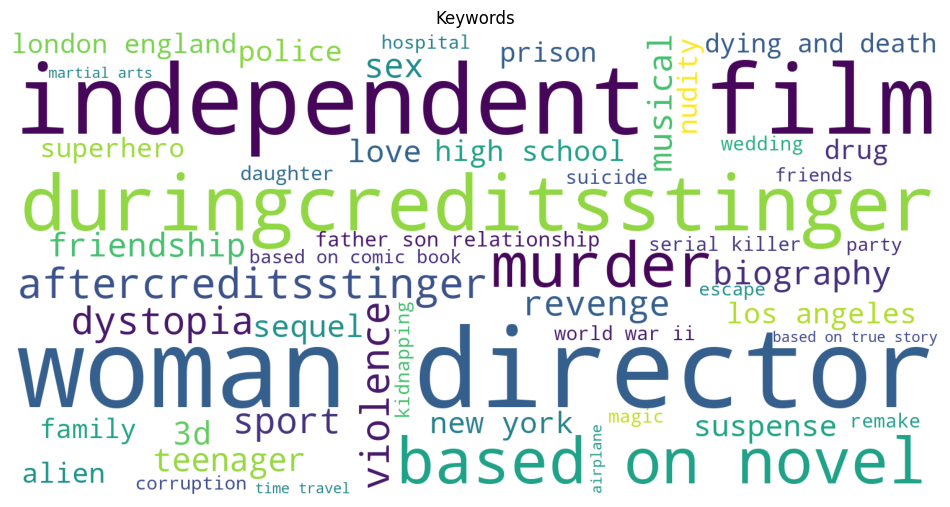

In [43]:
# Lấy danh sách từ khoá duy nhất từ cột 'keywords'
set_keywords = set(df.select("keywords").distinct().rdd.flatMap(lambda x: x).toLocalIterator())

# Loại bỏ giá trị rỗng
set_keywords.discard(None)

# Đếm số lần xuất hiện và lấy danh sách từ khoá theo thứ tự giảm dần
keyword_occurrences = list(count_word(df, 'keywords', set_keywords))

top_ten_keywords = top_ten(keyword_occurrences)

# Hiển thị top 10 từ khoá
print("Top 10 Keywords:", top_ten_keywords)

# Lấy danh sách từ khoá và số lần xuất hiện để tạo WordCloud
wordcloud_dict = {item[0]: item[1] for item in keyword_occurrences}
make_cloud(wordcloud_dict, "Keywords", "white")

In [44]:
# Thêm cột mới cho mỗi từ khoá trong top 10
for word in top_ten_keywords:
    df = df.withColumn(word, expr(f"CASE WHEN keywords LIKE '%{word}%' THEN 1 ELSE 0 END"))

In [45]:
# Chọn các cột "keywords" và các cột bắt đầu từ "woman director" trở đi và hiển thị
df.select(["keywords"] + [col(column) for column in df.columns[df.columns.index("woman director"):]]).show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+----------------+--------------------+--------------+------+-------------------+--------+--------+-----+-------+
|keywords                                                                                                                                                                                                                          |woman director|independent film|duringcreditsstinger|based on novel|murder|aftercreditsstinger|violence|dystopia|sport|revenge|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+----------------+--------------------+-------

In [46]:
# Tiến hành xóa thuộc tính "keywords" sau khi xử lý xong
df = df.drop("keywords")

### 3. production_companies: Thông tin về các công ty sản xuất tham gia vào việc sản xuất bộ phim

In [47]:
df.select("production_companies").show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------+
|production_companies                                                                                                            |
+--------------------------------------------------------------------------------------------------------------------------------+
|Walt Disney Pictures,Jerry Bruckheimer Films,Second Mate Productions                                                            |
|Columbia Pictures,Danjaq,B24                                                                                                    |
|Legendary Pictures,Warner Bros.,DC Entertainment,Syncopy                                                                        |
|Walt Disney Pictures                                                                                                            |
|Columbia Pictures,Laura Ziskin Productions,Marvel Enterprises                     

Có thể thấy có rất nhiều công ty sản xuất, để biến đổi các thuộc tính có nhiều giá trị danh mục, phương pháp đưa ra là ta sẽ lọc ra 50 công ty có tần suất xuất hiện nhiều nhất sau đó ánh xạ vào cột trên thành 50 cột tương ứng với 1 nếu công ty đó có tham gia sản xuất phim và 0 nếu ngược lại

Top 50 companies: ['Warner Bros.', 'Universal Pictures', 'Paramount Pictures', 'Twentieth Century Fox Film Corporation', 'Columbia Pictures', 'New Line Cinema', 'Metro-Goldwyn-Mayer (MGM)', 'Touchstone Pictures', 'Walt Disney Pictures', 'Relativity Media', 'Columbia Pictures Corporation', 'Miramax Films', 'Village Roadshow Pictures', 'DreamWorks SKG', 'Canal+', 'United Artists', 'Regency Enterprises', 'Fox Searchlight Pictures', 'Dune Entertainment', 'Lionsgate', 'Fox 2000 Pictures', 'TriStar Pictures', ' The', 'Dimension Films', 'Summit Entertainment', 'Working Title Films', 'Amblin Entertainment', 'The Weinstein Company', 'StudioCanal', 'Screen Gems', 'New Regency Pictures', 'Castle Rock Entertainment', 'Spyglass Entertainment', 'BBC Films', 'Scott Rudin Productions', 'Imagine Entertainment', 'Film4', 'Focus Features', 'UK Film Council', 'Davis Entertainment', 'Lions Gate Films', 'Legendary Pictures', 'Lakeshore Entertainment', 'Revolution Studios', 'Silver Pictures', 'Epsilon Motion

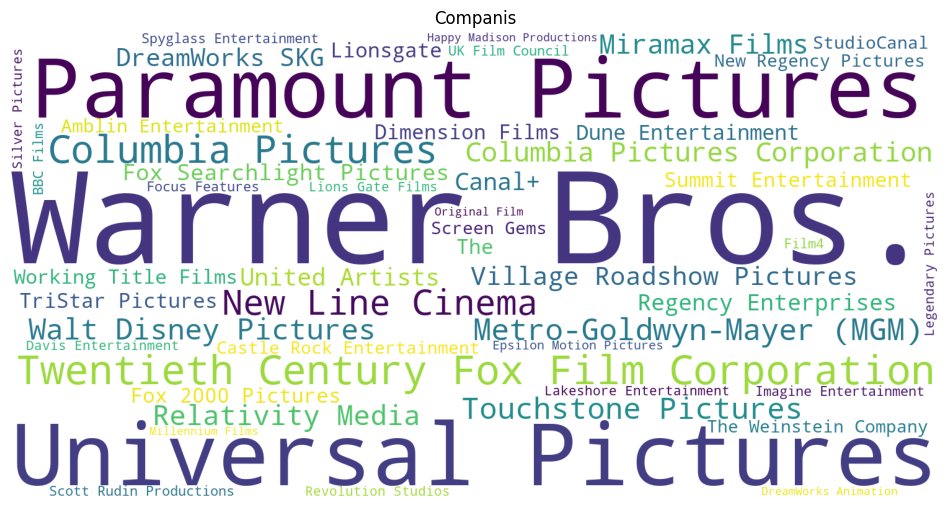

In [48]:
# Lấy danh sách công ty duy nhất từ cột 'production_companies'
set_companies = set(df.select("production_companies").distinct().rdd.flatMap(lambda x: x).toLocalIterator())

# Loại bỏ giá trị rỗng
set_companies.discard(None)

# Đếm số lần xuất hiện và lấy danh sách công ty theo thứ tự giảm dần
companies_occurrences = list(count_word(df, 'production_companies', set_companies))

top_fifty_companies = top_fifty(companies_occurrences)

# Hiển thị top 50 companies
print("Top 50 companies:", top_fifty_companies)

# Lấy danh sách công ty và số lần xuất hiện để tạo WordCloud
wordcloud_dict = {item[0]: item[1] for item in companies_occurrences}
make_cloud(wordcloud_dict, "Companis", "white")

In [49]:
# Thêm cột mới cho mỗi companies trong top 50 companies xuất hiện nhiều nhất
for word in top_fifty_companies:
    df = df.withColumn(word, expr(f"CASE WHEN production_companies LIKE '%{word}%' THEN 1 ELSE 0 END"))

In [50]:
# Đổi tên cột từ "Warner Bros." thành "WarnerBros"
df = df.withColumnRenamed("Warner Bros.", "Warner Bros")

In [51]:
# Chọn cột "production_companies" và các cột bắt đầu từ "Warner Bros." trở đi và hiển thị
df.select(["production_companies"] + [col("`{}`".format(column)) for column in df.columns[df.columns.index("Warner Bros"):]]).show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------+-----------+------------------+------------------+--------------------------------------+-----------------+---------------+-------------------------+-------------------+--------------------+----------------+-----------------------------+-------------+-------------------------+--------------+------+--------------+-------------------+------------------------+------------------+---------+-----------------+----------------+----+---------------+--------------------+-------------------+--------------------+---------------------+-----------+-----------+--------------------+-------------------------+----------------------+---------+-----------------------+---------------------+-----+--------------+---------------+-------------------+----------------+------------------+-----------------------+------------------+---------------+-----------------------+----------------

In [52]:
# Xóa thuộc tính "production_companies" sau khi xử lý
df = df.drop("production_companies")

### 4. release_date: Ngày phát hành của bộ phim.

In [53]:
df.select("release_date").show(truncate=False)

+------------+
|release_date|
+------------+
|2007-05-19  |
|2015-10-26  |
|2012-07-16  |
|2012-03-07  |
|2007-05-01  |
|2010-11-24  |
|2015-04-22  |
|2009-07-07  |
|2016-03-23  |
|2006-06-28  |
|2008-10-30  |
|2006-06-20  |
|2013-07-03  |
|2013-06-12  |
|2008-05-15  |
|2012-04-25  |
|2011-05-14  |
|2012-05-23  |
|2014-12-10  |
|2012-06-27  |
+------------+
only showing top 20 rows



Để cho mô hình có thể học được ta cần chuyển đổi thành dạng số, phương pháp lựa chọn là ta sẽ tiến hành tạo 3 thuộc tính mới chứa thông tin về ngày, tháng, năm mà bộ phim đó được phát hành

In [54]:
# Chuyển thuộc tính release_date về định dạng ngày
df = df.withColumn("release_date", to_date(df["release_date"]))
# Tách thuộc tính release_date thành 3 cột đại diện ngày, tháng, năm mà bộ phim phát hành
df = df.withColumn("release_year", year(df["release_date"]))
df = df.withColumn("release_month", month(df["release_date"]))
df = df.withColumn("release_day", dayofmonth(df["release_date"]))

In [55]:
# Chọn các cột "release_date" và các cột bắt đầu từ "release_year" trở đi và hiển thị
df.select(["release_date"] + [col(column) for column in df.columns[df.columns.index("release_year"):]]).show(truncate=False)

+------------+------------+-------------+-----------+
|release_date|release_year|release_month|release_day|
+------------+------------+-------------+-----------+
|2007-05-19  |2007        |5            |19         |
|2015-10-26  |2015        |10           |26         |
|2012-07-16  |2012        |7            |16         |
|2012-03-07  |2012        |3            |7          |
|2007-05-01  |2007        |5            |1          |
|2010-11-24  |2010        |11           |24         |
|2015-04-22  |2015        |4            |22         |
|2009-07-07  |2009        |7            |7          |
|2016-03-23  |2016        |3            |23         |
|2006-06-28  |2006        |6            |28         |
|2008-10-30  |2008        |10           |30         |
|2006-06-20  |2006        |6            |20         |
|2013-07-03  |2013        |7            |3          |
|2013-06-12  |2013        |6            |12         |
|2008-05-15  |2008        |5            |15         |
|2012-04-25  |2012        |4

In [56]:
# Xóa cột release_date
df = df.drop("release_date")

Ta thấy thuộc tính status chứa thông tin bao gồm : Released-4788, Remored-5, Post Production-3

Hầu hết đa số tất cả bộ phim đã phát hành, về mặt ý nghĩa thuộc tính này không mang lại ý nghĩa và kết quả tốt cho mô hình nên ta sẽ tiến hành loại bỏ 

### 5. actor: chứa thông tin tên của 3 diễn viên chính của bộ phim


In [57]:
df.select("actor").show(truncate=False)

+----------------------------------------------+
|actor                                         |
+----------------------------------------------+
|Johnny Depp,Orlando Bloom,Keira Knightley     |
|Daniel Craig,Christoph Waltz,Léa Seydoux      |
|Christian Bale,Michael Caine,Gary Oldman      |
|Taylor Kitsch,Lynn Collins,Samantha Morton    |
|Tobey Maguire,Kirsten Dunst,James Franco      |
|Zachary Levi,Mandy Moore,Donna Murphy         |
|Robert Downey Jr.,Chris Hemsworth,Mark Ruffalo|
|Daniel Radcliffe,Rupert Grint,Emma Watson     |
|Ben Affleck,Henry Cavill,Gal Gadot            |
|Brandon Routh,Kevin Spacey,Kate Bosworth      |
|Daniel Craig,Olga Kurylenko,Mathieu Amalric   |
|Johnny Depp,Orlando Bloom,Keira Knightley     |
|Johnny Depp,Armie Hammer,William Fichtner     |
|Henry Cavill,Amy Adams,Michael Shannon        |
|Ben Barnes,William Moseley,Anna Popplewell    |
|Robert Downey Jr.,Chris Evans,Mark Ruffalo    |
|Johnny Depp,Penélope Cruz,Ian McShane         |
|Will Smith,Tommy Le

Có thể thấy có rất nhiều diễn viên, để biến đổi các thuộc tính có nhiều giá trị danh mục, phương pháp đưa ra là ta sẽ lọc ra 20 diễn viên có tần suất xuất hiện nhiều nhất sau đó ánh xạ vào cột trên thành 20 cột tương ứng với 1 nếu diễn viên đó có đóng trong phim và 0 nếu ngược lại

Top 20 Actor: ['Robert De Niro', 'Samuel L. Jackson', 'Matt Damon', 'Bruce Willis', 'Nicolas Cage', 'Johnny Depp', 'Brad Pitt', 'Denzel Washington', 'Morgan Freeman', 'Tom Hanks', 'Ben Stiller', 'Eddie Murphy', 'Mark Wahlberg', 'Tom Cruise', 'John Travolta', 'Harrison Ford', 'George Clooney', 'Julia Roberts', 'Owen Wilson', 'Ewan McGregor']


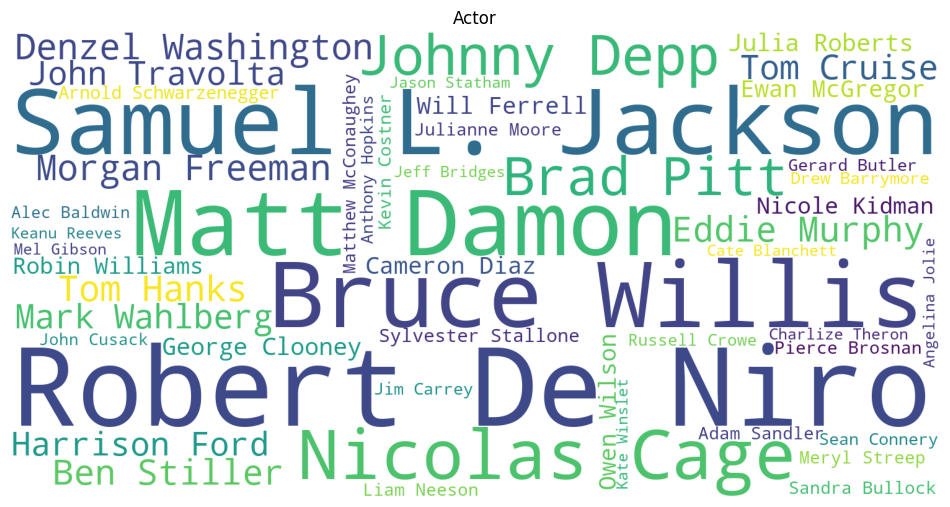

In [58]:
# Lấy danh sách actor duy nhất từ cột 'actor'
set_actor = set(df.select("actor").distinct().rdd.flatMap(lambda x: x).toLocalIterator())

# Loại bỏ giá trị rỗng
set_actor.discard(None)

# Đếm số lần xuất hiện và lấy danh sách actor theo thứ tự giảm dần
actor_occurrences = list(count_word(df, 'actor', set_actor))

top_twenty_actor = top_twenty(actor_occurrences)

# Hiển thị top 20 từ actor
print("Top 20 Actor:", top_twenty_actor)

# Lấy danh sách actor và số lần xuất hiện để tạo WordCloud
wordcloud_dict = {item[0]: item[1] for item in actor_occurrences}
make_cloud(wordcloud_dict, "Actor", "white")

In [59]:
# Thêm cột mới cho mỗi actor trong top 20
for word in top_twenty_actor:
    df = df.withColumn(word, expr(f"CASE WHEN actor LIKE '%{word}%' THEN 1 ELSE 0 END"))

In [60]:
df = df.withColumnRenamed("Samuel L. Jackson", "Samuel L Jackson")

In [61]:
# Chọn các cột "actor" và các cột bắt đầu từ "Robert De Niro" trở đi và hiển thị
df.select(["actor"] + [col("`{}`".format(column)) for column in df.columns[df.columns.index("Robert De Niro"):]]).show(truncate=False)

+----------------------------------------------+--------------+----------------+----------+------------+------------+-----------+---------+-----------------+--------------+---------+-----------+------------+-------------+----------+-------------+-------------+--------------+-------------+-----------+-------------+
|actor                                         |Robert De Niro|Samuel L Jackson|Matt Damon|Bruce Willis|Nicolas Cage|Johnny Depp|Brad Pitt|Denzel Washington|Morgan Freeman|Tom Hanks|Ben Stiller|Eddie Murphy|Mark Wahlberg|Tom Cruise|John Travolta|Harrison Ford|George Clooney|Julia Roberts|Owen Wilson|Ewan McGregor|
+----------------------------------------------+--------------+----------------+----------+------------+------------+-----------+---------+-----------------+--------------+---------+-----------+------------+-------------+----------+-------------+-------------+--------------+-------------+-----------+-------------+
|Johnny Depp,Orlando Bloom,Keira Knightley     |0   

In [62]:
# Xóa thuộc tính actor sau khi xử lý xong
df = df.drop("actor")

### 6. director: chứa thông tin tên đạo diễn của bộ phim

In [63]:
df.select("director").show(truncate=False)

+-------------------------+
|director                 |
+-------------------------+
|Gore Verbinski           |
|Sam Mendes               |
|Christopher Nolan        |
|Andrew Stanton           |
|Sam Raimi                |
|Byron Howard,Nathan Greno|
|Joss Whedon              |
|David Yates              |
|Zack Snyder              |
|Bryan Singer             |
|Marc Forster             |
|Gore Verbinski           |
|Gore Verbinski           |
|Zack Snyder              |
|Andrew Adamson           |
|Joss Whedon              |
|Rob Marshall             |
|Barry Sonnenfeld         |
|Peter Jackson            |
|Marc Webb                |
+-------------------------+
only showing top 20 rows



Với thuộc tính "director" ta sẽ tiến hành trích xuất 10 nhà đạo diễn có tần xuất xuất hiện nhiều nhất sau đó ánh xạ từ thuộc tính gốc thành 10 thuộc tính mới tương ứng phản ánh tác giả của bộ phim

In [64]:
# Lọc các dòng có giá trị không hợp lệ trong cột 'director'
df = df.filter(col("director") != "")

def to_frequency_table(data, column_name):
    frequency_table = data.groupBy(column_name).count().withColumnRenamed("count", "frequency")
    return frequency_table

In [65]:
# Tạo bảng tần suất cho thuộc tính 'director'
director_table = to_frequency_table(df, "director")

In [66]:
# Sắp xếp theo tần suất giảm dần
director_table = director_table.orderBy(col("frequency").desc())

In [67]:
# Hiển thị top 10 director
director_table.show(10)

+-----------------+---------+
|         director|frequency|
+-----------------+---------+
| Steven Spielberg|       26|
|      Woody Allen|       21|
|  Martin Scorsese|       20|
|   Clint Eastwood|       20|
|     Ridley Scott|       16|
|        Spike Lee|       16|
|Steven Soderbergh|       15|
|     Renny Harlin|       15|
|     Oliver Stone|       14|
|  Robert Zemeckis|       13|
+-----------------+---------+
only showing top 10 rows



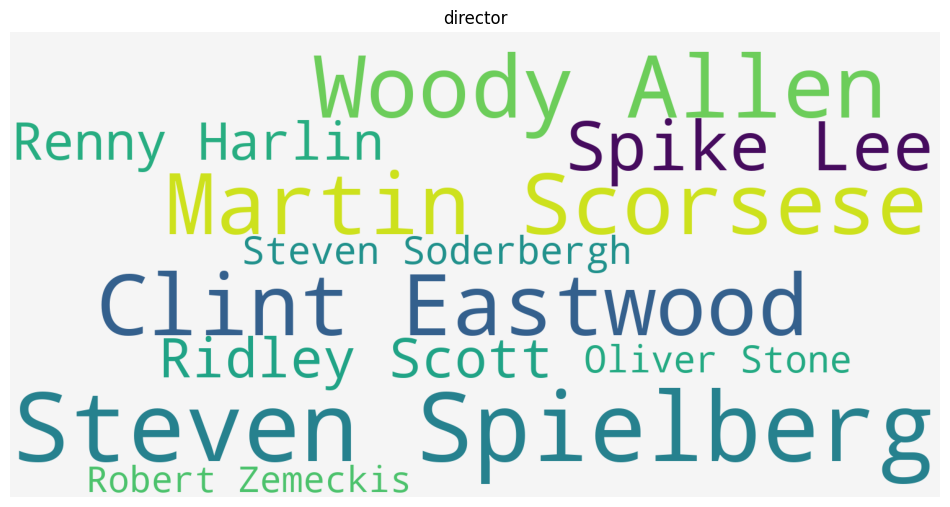

In [68]:
# Giới hạn kết quả chỉ lấy 10 dòng đầu
top_directors = director_table.limit(10)

# Chuyển đổi PySpark DataFrame thành Pandas DataFrame để sử dụng với hàm make_cloud
director_pd = top_directors.toPandas()

# Chuyển đổi Pandas DataFrame thành từ điển để sử dụng với hàm make_cloud
director_dict = dict(zip(director_pd['director'], director_pd['frequency']))

# Gọi hàm make_cloud với dữ liệu từ điển
make_cloud(director_dict, "director", "whitesmoke")

director_list = list(director_dict.items())

In [69]:
for word in top_ten(director_list):
    # Tạo cột mới với giá trị 1 nếu đạo diễn xuất hiện trong top 10 director, ngược lại là 0
    df = df.withColumn(word, when(col('director').contains(word), 1).otherwise(0))

In [70]:
# Chọn các cột "director" và các cột bắt đầu từ "Steven Spielberg" trở đi và hiển thị
df.select(["director"] + [col(column) for column in df.columns[df.columns.index("Steven Spielberg"):]]).show(truncate=False)

+-------------------------+----------------+-----------+---------------+--------------+---------+------------+------------+-----------------+------------+---------------+
|director                 |Steven Spielberg|Woody Allen|Martin Scorsese|Clint Eastwood|Spike Lee|Ridley Scott|Renny Harlin|Steven Soderbergh|Oliver Stone|Robert Zemeckis|
+-------------------------+----------------+-----------+---------------+--------------+---------+------------+------------+-----------------+------------+---------------+
|Gore Verbinski           |0               |0          |0              |0             |0        |0           |0           |0                |0           |0              |
|Sam Mendes               |0               |0          |0              |0             |0        |0           |0           |0                |0           |0              |
|Christopher Nolan        |0               |0          |0              |0             |0        |0           |0           |0                |0   

In [71]:
# Xóa thuộc tính "director" sau khi xử lý xong
df = df.drop("director")

In [72]:
df.show()

+---------+------+--------------------+----------+----------+-------+------------+----------+-----+-------+--------+---------+-----+---+------+-------+-------+-------+---------+-----+---------------+------+-------+------+------+-----------+-------+--------+--------------+----------------+--------------------+--------------+------+-------------------+--------+--------+-----+-------+-----------+------------------+------------------+--------------------------------------+-----------------+---------------+-------------------------+-------------------+--------------------+----------------+-----------------------------+-------------+-------------------------+--------------+------+--------------+-------------------+------------------------+------------------+---------+-----------------+----------------+----+---------------+--------------------+-------------------+--------------------+---------------------+-----------+-----------+--------------------+-------------------------+-----------------

In [73]:
# Hiển thị thông tin dữ liệu
num_rows = df.count()
print(f"Số dòng: {num_rows}")
num_columns = len(df.columns)
print(f"Số cột: {num_columns}")

Số dòng: 4766
Số cột: 121


## Feature Selection

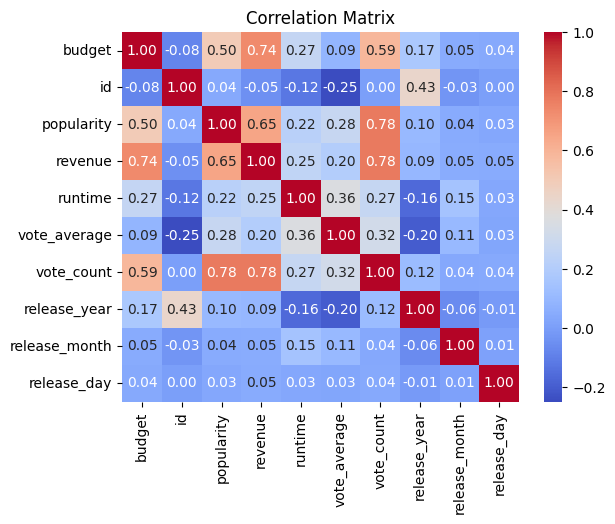

In [74]:
# Chuyển đổi DataFrame PySpark thành DataFrame pandas
pandas_df = df.select("budget","id", "popularity","revenue", "runtime","vote_average","vote_count","release_year","release_month","release_day").toPandas()

# Vẽ biểu đồ ma trận tương quan bằng seaborn
correlation_matrix = pandas_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Đối với tập dữ liệu các thuộc tính đều có ý nghĩa quan trọng nhất định, ta thấy có các cặp thuộc tính có độ tương quan cao như (chọn ngưỡng tương quan cao là 0.7):
+ budger - revennue
+ popularity - vote_count
+ revenue - vote_count 

-> Đối với cặp đầu tiên ta sẽ không lại bỏ 1 trong hai bởi vì ta sẽ dùng cặp thuộc tính nó cho bài toán phân loại

-> Đối với 2 cặp tiếp theo, giải pháp là ta sẽ loại bỏ thuộc tính vote_count


In [75]:
# Loại bỏ thuộc tính vote_count
df = df.drop("vote_count")

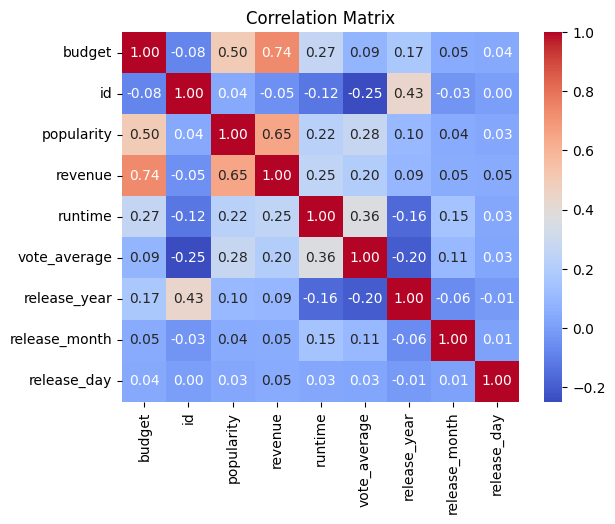

In [76]:
# Chuyển đổi DataFrame PySpark thành DataFrame pandas
pandas_df = df.select("budget","id", "popularity","revenue", "runtime","vote_average","release_year","release_month","release_day").toPandas()

# Vẽ biểu đồ ma trận tương quan bằng seaborn
correlation_matrix = pandas_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Model trainning and testing (using KNN)


The k-nearest neighbors algorithm, also known as KNN or k-NN, is a non-parametric, supervised learning classifier, which uses proximity to make classifications or predictions about the grouping of an individual data point.

## KNN Regression: Đối với bài toán dự đoán ta sẽ tiến hành chọn biến mục tiêu là vote_average: Điểm đánh giá trung bình của bộ phim

In [77]:
df.show()

+---------+------+--------------------+----------+----------+-------+------------+-----+-------+--------+---------+-----+---+------+-------+-------+-------+---------+-----+---------------+------+-------+------+------+-----------+-------+--------+--------------+----------------+--------------------+--------------+------+-------------------+--------+--------+-----+-------+-----------+------------------+------------------+--------------------------------------+-----------------+---------------+-------------------------+-------------------+--------------------+----------------+-----------------------------+-------------+-------------------------+--------------+------+--------------+-------------------+------------------------+------------------+---------+-----------------+----------------+----+---------------+--------------------+-------------------+--------------------+---------------------+-----------+-----------+--------------------+-------------------------+----------------------+-----

In [78]:
selected_columns = [col for col in df.columns if col not in ["vote_average","original_title"]]

In [79]:
df_regression = df.select("id","original_title","vote_average", f.array(*selected_columns).alias("feature"))
df_regression.show(truncate=False)

+------+-------------------------------------------+------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id    |original_title                             |vote_average|feature                                                                                                                                                                                                                                                

In [80]:
df_regression.printSchema()

root
 |-- id: integer (nullable = true)
 |-- original_title: string (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- feature: array (nullable = false)
 |    |-- element: double (containsNull = true)



In [81]:
train, test = df_regression.randomSplit([0.7, 0.3])

In [82]:
# Train data
train = train.select(col("feature"), col("vote_average"))
train.take(1)

# Test data
test = test.select(col("feature").alias("test_feature"), col("id").alias("test_id")).dropDuplicates()
test.take(1)

[Row(test_feature=[185000000.0, 155.0, 187.322927, 1004558444.0, 152.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2008.0, 7.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], test_id=155)]

In [83]:
def cos(x,y):
    s = 0
    for i,j in zip(x,y):
        s = s + i*j
    return s/(norm(x)*norm(y))

class KNearestNeighborsRegression:
    #khởi tạo giá trị ban đầu
    def __init__(self, train, test, k):
        self.train = train
        self.test = test
        self.k = k
        
    def get_predict(self):
        k = self.k
        tr = self.train
        td = self.test
        join_df = tr.crossJoin(td)
        cos_map_df = join_df\
                    .rdd.map(lambda x: (float(cos(x.feature,x.test_feature)), x.vote_average, x.test_id))\
                    .toDF(["cos", "vote_average", "test_id"])
        windowDept = Window.partitionBy("test_id").orderBy(col("cos").desc(), col("vote_average").desc())
    
        top_k_nearest_items_df = cos_map_df\
                                .withColumn("row",row_number().over(windowDept)).filter(col("row") <= k)
        vote_average_predict_df = top_k_nearest_items_df.rdd.map(lambda x: (x.test_id, x.cos*x.vote_average))\
                                                    .reduceByKey(add)\
                                                    .map(lambda x: (x[0], (x[1]/k)))\
                                                    .toDF(["id", "vote_average_predict"])\
                                                    .orderBy(col("vote_average_predict").desc())\
                                                    
        return vote_average_predict_df
    
    def evaluate(self):
        k = self.k
        w = self.train.orderBy(f.rand())
        test_size = int(w.count()/4)
        test_df = w.limit(test_size)
        train_df = w.subtract(test_df)
        test_df = test_df.withColumnRenamed("feature", "test_feature")\
                                    .withColumn("test_id", monotonically_increasing_id())
        
        actual_vote_average = test_df.select(col("test_id"), col("vote_average").alias("actual_vote_average"))
        
        join_df = train_df.crossJoin(test_df)
    
        cos_map_df = join_df\
                    .rdd.map(lambda x: (float(cos(x.feature,x.test_feature)), x.vote_average, x.test_id))\
                    .toDF(["cosine_score", "vote_average", "test_id"])
    
        windowDept = Window.partitionBy("test_id").orderBy(col("cosine_score").desc(), col("vote_average").desc())
    
        top_k_nearest_items_df = cos_map_df\
                                .withColumn("row",row_number().over(windowDept)).filter(col("row") <= k)
    
        vote_average_predict_df = top_k_nearest_items_df.rdd.map(lambda x: (x.test_id, x.cosine_score*x.vote_average))\
                                                    .reduceByKey(add)\
                                                    .map(lambda x: (x[0], x[1]/k))\
                                                    .toDF(["test_id", "vote_average_predict"])
        
        join_df = vote_average_predict_df.join(actual_vote_average, ["test_id"])

        # Calculate RMSE, MSE, and MAE
        result_rdd = join_df.rdd.map(lambda x: ((x.vote_average_predict - x.actual_vote_average) ** 2))
        rmse = (result_rdd.reduce(add) / result_rdd.count()) ** 0.5

        mse = (result_rdd.reduce(add) / result_rdd.count())

        result_rdd1 = join_df.select(abs(col("vote_average_predict") - col("actual_vote_average")).alias("mae"))
        mae = result_rdd1.rdd.map(lambda x: x.mae).reduce(add) / result_rdd1.count()

        return {"RMSE": rmse, "MAE": mae, "MSE": mse}

In [84]:
# Tiến hành dự đoán với k = 3
knn = KNearestNeighborsRegression(train, test, 3)

In [85]:
# Đánh giá kết quả dự đoán với độ đo RMSE, MAE, MSE
evaluation_metrics = knn.evaluate()
print("RMSE:", evaluation_metrics["RMSE"])
print("MAE:", evaluation_metrics["MAE"])
print("MSE:", evaluation_metrics["MSE"])

RMSE: 1.1303449669400396
MAE: 0.8461152781454379
MSE: 1.2776797442866794


In [86]:
# In ra kết quả dự đoán từ mô hình
vote_average_predict=knn.get_predict().show()

+-----+--------------------+
|   id|vote_average_predict|
+-----+--------------------+
|15121|   7.766662951159089|
|72213|   7.766643693840879|
| 9725|   7.733332443356076|
| 8810|    7.73333225390648|
|  218|    7.73333221759182|
|  630|   7.733329178396727|
|   87|   7.666665426529754|
|30315|   7.666646905560896|
|  621|     7.6333322886935|
|  642|   7.633331717941435|
|  153|   7.633330996147213|
| 1892|   7.599998169272418|
|  455|    7.53333306393144|
|  704|  7.5333327502627085|
|  310|     7.4666658796144|
|85350|   7.433329041427638|
|13282|    7.43332044659702|
|  679|   7.399999506581975|
| 9032|    7.36666664876696|
|  790|   7.366665353298678|
+-----+--------------------+
only showing top 20 rows



## KNN Classifier: Đối với bài toán phân lớp ta sẽ tạo biến mục tiêu dựa trên 2 biến là budget: Số tiền ngân sách được phân bổ để sản xuất bộ phim và revenue: Doanh thu mà bộ phim đạt được. Về cơ bản hầu hết các nhà làm phim đều mong muốn danh thu bộ phim của họ đạt gấp đôi kinh phí bỏ ra nên để ta sẽ tạo biến mục tiêu "is_successful" với 1 là bộ phim đó thành công (đạt lợi nhuận gấp đôi kinh phí) và 0 nếu ngược lại

In [87]:
df = df.withColumn("is_successful", when(col("revenue") >= col("budget") * 2, 1).otherwise(0))

In [88]:
# Xóa các thuộc tính không cần thiết cho việc dự đoán vì dự đoán sự thành công của bộ phim nên các thuộc tính như 
# điểm rating, số lượng rating, doanh thu đều là các yếu tố biết sau sau khi bộ phim phát hành
df_classifier = df.drop("original_title","popularity","id","vote_average","revenue")

In [89]:
df_classifier.show()

+---------+-------+-----+-------+--------+---------+-----+---+------+-------+-------+-------+---------+-----+---------------+------+-------+------+------+-----------+-------+--------+--------------+----------------+--------------------+--------------+------+-------------------+--------+--------+-----+-------+-----------+------------------+------------------+--------------------------------------+-----------------+---------------+-------------------------+-------------------+--------------------+----------------+-----------------------------+-------------+-------------------------+--------------+------+--------------+-------------------+------------------------+------------------+---------+-----------------+----------------+----+---------------+--------------------+-------------------+--------------------+---------------------+-----------+-----------+--------------------+-------------------------+----------------------+---------+-----------------------+---------------------+-----+------

In [90]:
# Chia tập dữ liệu với tỉ lệ train:test là 7:3
train_data, test_data = df_classifier.randomSplit([0.7, 0.3], seed=42)

In [91]:
decision_attribute = 'is_successful'
feature_columns = [column for column in df_classifier.columns if column != decision_attribute]

In [92]:
# Hàm tính khoảng cách
def euclidean_distance(row1, row2):
    distance = 0
    for column in feature_columns:
        distance += (row1[column] - row2[column]) ** 2
    return distance**0.5

Sử dụng hàm broadcast để broadcast dữ liệu huấn luyện (train_data.rdd.collect()) từ node chủ đến tất cả các node làm việc. Dữ liệu huấn luyện được thu thập thành một danh sách (list) để broadcast.

Chuyển đổi DataFrame test_data thành một Resilient Distributed Dataset (RDD) để có thể thực hiện các phép biến đổi và hành động xử lý song song

In [93]:
# Broadcast train_data to all worker nodes
broadcast_train_data = sc.broadcast(train_data.rdd.collect())

# Convert the test_data DataFrame to an RDD for parallel processing
test_data_rdd = test_data.rdd


### Step 1 - Tính khoảng cách Euclidean và Tìm k Láng giềng Gần Nhất
1. Tính khoảng cách Euclidean:
+ Duyệt qua mỗi hàng trong tập kiểm thử (test_data_rdd).
+ Với mỗi hàng kiểm thử, tính khoảng cách Euclidean đến mỗi hàng trong tập huấn luyện (train_data_broadcast.value).

2. Lựa chọn k láng giềng gần nhất:

+ Đối với mỗi hàng kiểm thử, tạo một danh sách các khoảng cách Euclidean đến các hàng trong tập huấn luyện cùng với nhãn "is_successful" tương ứng.
+ Sắp xếp danh sách này theo thứ tự tăng dần của khoảng cách Euclidean.
+ Giữ lại nhãn "is_successful" của mỗi hàng trong tập huấn luyện tương ứng.
+ Lựa chọn k giá trị nhỏ nhất từ danh sách đã sắp xếp.

3. Lưu trữ kết quả cho mỗi hàng kiểm thử:

+ Lưu trữ nhãn "is_successful" của k láng giềng gần nhất.
+ Tạo tuples gồm nhãn "is_successful" và khoảng cách Euclidean của k láng giềng gần nhất cho mỗi hàng kiểm thử.

4. Kiểm thử với các giá trị k khác nhau:

+ Thực hiện các bước 1-3 với các giá trị k khác nhau để kiểm thử sự ảnh hưởng của giá trị k đối với dự đoán của mô hình (tinh chỉnh siêu tham số - hyperparameter tuning).
python

In [94]:
# Function to calculate Euclidean distance between two rows
def euclidean_distance(row1, row2):
    distance = 0
    for column in feature_columns:
        distance += (row1[column] - row2[column]) ** 2
    return distance**0.5

k = 10 

# Function to find k neighbors for each test row
def find_neighbors(iter, train_data_broadcast):
    distances = []
    for test_row in iter:
        for train_row in train_data_broadcast.value:
            euc_dist = euclidean_distance(test_row, train_row)
            distances.append((euc_dist, train_row['is_successful']))
        distances.sort(key=lambda x: x[0])
        yield distances[:k]

# Use mapPartitions transformation to find neighbors for each test row in parallel
test_neighbors_rdd = test_data_rdd.mapPartitions(lambda iter: find_neighbors(iter, broadcast_train_data))

### Step 2 - Dự đoán

Sử dụng mapPartitions để áp dụng hàm find_neighbors và tìm ra k láng giềng gần nhất cho mỗi hàng trong tập kiểm thử (test_data_rdd) dựa trên tập huấn luyện (broadcast_train_data). Kết quả được lưu trữ trong test_neighbors_rdd.

Sau đó, sử dụng hàm predict_class để dự đoán lớp cho mỗi hàng trong tập kiểm thử dựa trên nhãn của k láng giềng gần nhất.

Kết quả dự đoán được thu thập từ test_predictions_rdd bằng cách sử dụng collect() để có danh sách dự đoán cuối cùng cho tất cả các hàng trong tập kiểm thử, được lưu trữ trong biến test_predictions.

In [95]:
# Use mapPartitions transformation to find neighbors for each test row in parallel
test_neighbors_rdd = test_data_rdd.mapPartitions(lambda iter: find_neighbors(iter, broadcast_train_data))

# Function to predict classes based on neighbors
def predict_class(neighbors):
    classes = [neighbor[1] for neighbor in neighbors]
    counter = Counter(classes)
    most_common_class = counter.most_common(1)[0][0]
    return most_common_class

# Use map transformation to predict classes for each test row in parallel
test_predictions_rdd = test_neighbors_rdd.map(predict_class)

test_predictions = test_predictions_rdd.collect()

### Step 3 - Đánh giá độ chính xác của mô hình

In [96]:
# Lấy nhãn của tập test để tiến hành đánh giá độ chính xác
test_labels = [row['is_successful'] for row in test_data.select('is_successful').rdd.collect()]

In [97]:
# Function to calculate accuracy
def accuracy_score(y_pred, y_test):
    correct_predictions = len([pred for pred, true_label in zip(y_pred, y_test) if pred == true_label])
    total_predictions = len(y_pred)
    accuracy = (correct_predictions / total_predictions) * 100
    return accuracy

In [98]:
# Calculate and print accuracy
accuracy_test = accuracy_score(test_predictions, test_labels)
print('The accuracy score for KNN test is:', accuracy_test)

The accuracy score for KNN test is: 57.8506629448709


### Step 4 - In ra kết quả dự đoán

In [99]:
# Tạo DataFrame từ list của tuples
results_data = [(predicted_label, actual_label) for predicted_label, actual_label in zip(test_predictions, test_labels)]
df_results = spark.createDataFrame(results_data, ["KNN Model Predicted Labels with k=10", "Actual Labels"])

# Hiển thị kết quả
df_results.show()

+------------------------------------+-------------+
|KNN Model Predicted Labels with k=10|Actual Labels|
+------------------------------------+-------------+
|                                   0|            0|
|                                   0|            1|
|                                   0|            1|
|                                   0|            0|
|                                   0|            0|
|                                   0|            1|
|                                   0|            0|
|                                   1|            1|
|                                   0|            1|
|                                   0|            0|
|                                   0|            0|
|                                   1|            1|
|                                   1|            1|
|                                   1|            1|
|                                   1|            0|
|                                   1|        